## Evaluating GeoAI model with Synthetic Flood Labels using GeoAugment

> From USGS, download SRTM **Digital Elevation Model (DEM)** = physical terrain

> From Copernicus EMS, download observed flood extent (**real flood data**)

> **GeoAugment** (the tool) = physics-constrained label generator

## Classification - Test Label Quality
> Input: DEM patch

> Target: binary flood mask (per pixel)

>Output: flood probability per pixel

In [1]:
# installations
!pip install torch torchvision torchaudio
!pip install geoaugment==0.1.8 --quiet

In [2]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm

In [3]:
from geo_augment.domains.floods.api import synthesize_flood_risk
from geo_augment.domains.floods.threshold import apply_threshold

# Evaluation utilities
from geo_augment.domains.floods.spec import (
    DEFAULT_FLOOD_SPEC,
    DEFAULT_FLOOD_CONSTRAINTS,
    DEFAULT_LATENT_SPEC,
)


# Optional post-processing
from geo_augment.domains.floods.threshold import apply_percentile_threshold
from geo_augment.evaluation.floods import flooded_area_ratio
from geo_augment.evaluation.floods import (
    distribution_summary,
    spatial_correlation,
)

In [4]:
# GeoAugment core
from geo_augment.io.raster import RasterLoader
from geo_augment.domains.floods import (
    synthesize_flood_risk,
    synthesize_flood_labels,
    stack_flood_features,
    FloodSynthesisSpec,
    FloodConstraints,
    LatentFloodFieldSpec,
)

## Input data and meaning

SRTM DEM = physical terrain

Copernicus EMS = observed flood extent

~GeoAugment = physics-constrained label generator~

When alignment is required, load Digital Elevation Model (DEM) with metadata.

**Note**: Use Rasterio instead of RasterLoader

In [5]:
with rasterio.open("LagosDEM.tif") as src:
    dem = src.read(1)
    dem_meta = src.meta

## Load Copernicus flood tiles

In [6]:
flood_files = [
    "AF_E033N057T3_ENSEMBLE_FLOOD_20260118T053002_VV_AF020M_E033N057T3_20260118.tif",
    "AF_E036N054T3_ENSEMBLE_FLOOD_20260118T053002_VV_AF020M_E036N054T3_20260118.tif",
    "AF_E036N057T3_ENSEMBLE_FLOOD_20260118T053002_VV_AF020M_E036N057T3_20260118.tif"
]

srcs = [rasterio.open(f) for f in flood_files]
flood_merged, flood_transform = merge(srcs)
real_flood = flood_merged[0]

## Reproject & Resample flood labels to DEM grid

In [7]:
aligned_flood = np.zeros_like(dem, dtype=np.uint8)

reproject(
    source = real_flood,
    destination = aligned_flood,
    src_transform = flood_transform,
    src_crs = srcs[0].crs,
    dst_transform = dem_meta["transform"],
    dst_crs = dem_meta["crs"],
    resampling = Resampling.nearest, # important for risk labels
)

(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 Affine(0.0002777777777777778, 0.0, 2.999861111111111,
        0.0, -0.0002777777777777778, 7.000138888888889))

In [8]:
# Copernicus flood: treat flooded >= 1 as flooded
aligned_flood = (aligned_flood >= 1).astype(np.float32)

## Generate Synthetic Flood Risk

In [9]:
synthetic_risk = synthesize_flood_risk(
    dem=dem,
    synthesis_spec=DEFAULT_FLOOD_SPEC,
    constraints=DEFAULT_FLOOD_CONSTRAINTS,
    latent_spec=DEFAULT_LATENT_SPEC,
    n_samples=1
)[0]

## Convert to binary flood labels

In [10]:
synthetic_labels = apply_percentile_threshold(synthetic_risk)

## Visualize

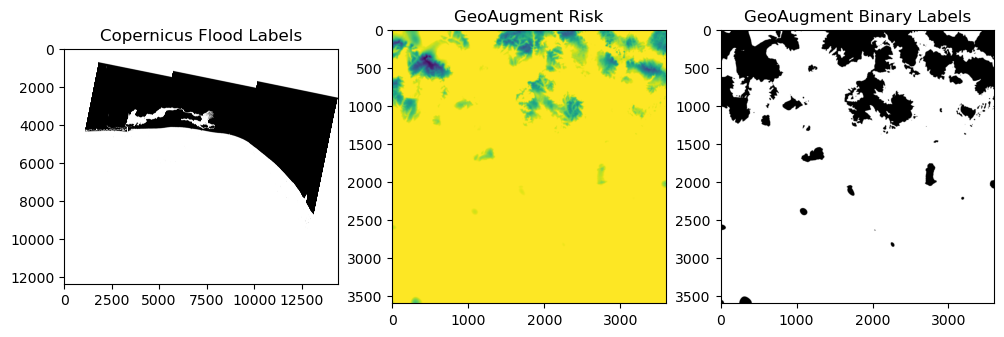

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(real_flood, cmap="gray")
plt.title("Copernicus Flood Labels")

plt.subplot(1, 3, 2)
plt.imshow(synthetic_risk, cmap="viridis")
plt.title("GeoAugment Risk")

plt.subplot(1, 3, 3)
plt.imshow(synthetic_labels, cmap="gray")
plt.title("GeoAugment Binary Labels")

plt.show()

## Prepare CNN input (Tensor)
CNNs expect images.
We convert DEM into image-like tensor.

In [12]:
dem_tensor = torch.tensor(dem, dtype=torch.float32).unsqueeze(0)
real_tensor = torch.tensor(aligned_flood, dtype=torch.float32)
synthetic_tensor = torch.tensor(synthetic_labels, dtype=torch.float32)

## Normalize DEM

In [13]:
dem_tensor = (dem_tensor - dem_tensor.min()) / (dem_tensor.max() - dem_tensor.min())

## Sanity check

In [14]:
assert dem_tensor.shape[-2:] == real_tensor.shape[-2:]
assert dem_tensor.shape[-2:] == synthetic_tensor.shape[-2:]

print("DEM shape:", dem_tensor.shape)
print("Real flood shape:", real_tensor.shape)
print("Synthetic flood shape:", synthetic_tensor.shape)

DEM shape: torch.Size([1, 3601, 3601])
Real flood shape: torch.Size([3601, 3601])
Synthetic flood shape: torch.Size([3601, 3601])


### Patch extraction

**Note**: CNNs do not train on full raster but learn local spatial patterns (not entire regions)

In [15]:
def extract_patches(image, label, patch_size=64, stride=32):
    patches = []
    labels = []

    _, H, W = image.shape

    for i in range(0, H - patch_size, stride):
        for j in range(0, W - patch_size, stride):
            img_patch = image[:, i:i+patch_size, j:j+patch_size]
            lbl_patch = label[i:i+patch_size, j:j+patch_size]

            patches.append(img_patch)
            labels.append(lbl_patch)

    return torch.stack(patches), torch.stack(labels)

## Generate Dataset (Real vs Synthetic)

In [16]:
X_real, y_real = extract_patches(
    dem_tensor,
    real_tensor,
    patch_size = 64
)

X_syn, y_syn = extract_patches(
    dem_tensor,
    synthetic_tensor,
    patch_size = 64
)

print(X_real.shape, y_real.shape)
print(X_syn.shape, y_syn.shape)

torch.Size([12321, 1, 64, 64]) torch.Size([12321, 64, 64])
torch.Size([12321, 1, 64, 64]) torch.Size([12321, 64, 64])


## Train / Validation Split

In [17]:
def split_dataset(
    X, y, test_size = 0.2):
    return train_test_split(
        X, y, test_size=test_size, random_state=42
    )

Xr_train, Xr_val, yr_train, yr_val = split_dataset(X_real, y_real)
Xs_train, Xs_val, ys_train, ys_val = split_dataset(X_syn, y_syn)

## Pytorch Dataset Class

In [18]:
class FloodDataset(Dataset):
    def __init__(self, X, y):
        # Your data is already in patches, so just store them
        self.X = X if torch.is_tensor(X) else torch.tensor(X, dtype=torch.float32)
        self.y = y if torch.is_tensor(y) else torch.tensor(y, dtype=torch.float32)
        
        # If your patches don't have a channel dimension yet, add it
        if self.X.ndimension() == 3: # (N, H, W) -> (N, 1, H, W)
            self.X = self.X.unsqueeze(1)
            
        print(f"Dataset Initialized: {self.X.shape[0]} samples of shape {self.X.shape[1:]}")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### DataLoaders for 3 experiments

In [19]:
batch_size = 16

# Model A: Real only
train_real = DataLoader(
    FloodDataset(Xr_train, yr_train),
    batch_size=batch_size,
    shuffle=True
)
val_real = DataLoader(
    FloodDataset(Xr_val, yr_val),
    batch_size=batch_size
)

# Model B: Synthetic only
train_syn = DataLoader(
    FloodDataset(Xs_train, ys_train),
    batch_size=batch_size,
    shuffle=True
)
val_syn = DataLoader(
    FloodDataset(Xs_val, ys_val),
    batch_size=batch_size
)

# Model C: Real + Synthetic
X_combined = torch.cat([Xr_train, Xs_train])
y_combined = torch.cat([yr_train, ys_train])

train_mix = DataLoader(
    FloodDataset(X_combined, y_combined),
    batch_size=batch_size,
    shuffle=True
)

Dataset Initialized: 9856 samples of shape torch.Size([1, 64, 64])
Dataset Initialized: 2465 samples of shape torch.Size([1, 64, 64])
Dataset Initialized: 9856 samples of shape torch.Size([1, 64, 64])
Dataset Initialized: 2465 samples of shape torch.Size([1, 64, 64])
Dataset Initialized: 19712 samples of shape torch.Size([1, 64, 64])


## Model Definition - Segmentation (Classification)

In [20]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Basic Encoder: Process 1-channel DEM
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )
        # Basic Decoder: Output 1-channel Mask
        self.decoder = nn.Sequential(            
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1) # Output 1 channel (logits)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

## Training Loop

In [24]:
#THE TRAINING FUNCTION
def train_model(model, train_loader, val_loader, device, epochs=5):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # BCEWithLogitsLoss is best for binary pixels (flood vs no-flood)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
             # model(X) outputs [16, 1, 64, 64]
             # .squeeze(1) changes it to [16, 64, 64] to match y
            outputs = model(X).squeeze(1)
            loss = criterion(outputs, y)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss/len(train_loader):.4f}")

# EXECUTION
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train the 3 models

In [25]:
print("Training Model A (Real Only)...")
model_a = SimpleUNet()
train_model(model_a, train_real, val_real, device)

print("\nTraining Model B (Synthetic Only)...")
model_b = SimpleUNet()
train_model(model_b, train_syn, val_real, device) # Validating against Real data is best practice

print("\nTraining Model C (Mixed Real + Synthetic)...")
model_c = SimpleUNet()
train_model(model_c, train_mix, val_real, device)

Training Model A (Real Only)...
Epoch 1/5 - Loss: 0.4338
Epoch 2/5 - Loss: 0.2200
Epoch 3/5 - Loss: 0.1939
Epoch 4/5 - Loss: 0.1847
Epoch 5/5 - Loss: 0.1811

Training Model B (Synthetic Only)...
Epoch 1/5 - Loss: 0.2953
Epoch 2/5 - Loss: 0.2133
Epoch 3/5 - Loss: 0.2113
Epoch 4/5 - Loss: 0.2104
Epoch 5/5 - Loss: 0.2104

Training Model C (Mixed Real + Synthetic)...
Epoch 1/5 - Loss: 0.4539
Epoch 2/5 - Loss: 0.3978
Epoch 3/5 - Loss: 0.3903
Epoch 4/5 - Loss: 0.3876
Epoch 5/5 - Loss: 0.3866


## Evaluation

In [47]:
def evaluate(model, dataloader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device).float()

            logits = model(X).squeeze()
            probs = torch.sigmoid(logits)

            preds.append((probs > 0.5).cpu().flatten())
            targets.append(y.cpu().flatten())

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    return {
        "accuracy": accuracy_score(targets, preds),
        "precision": precision_score(targets, preds, zero_division=0),
        "recall": recall_score(targets, preds, zero_division=0),
        "f1": f1_score(targets, preds, zero_division=0),
    }

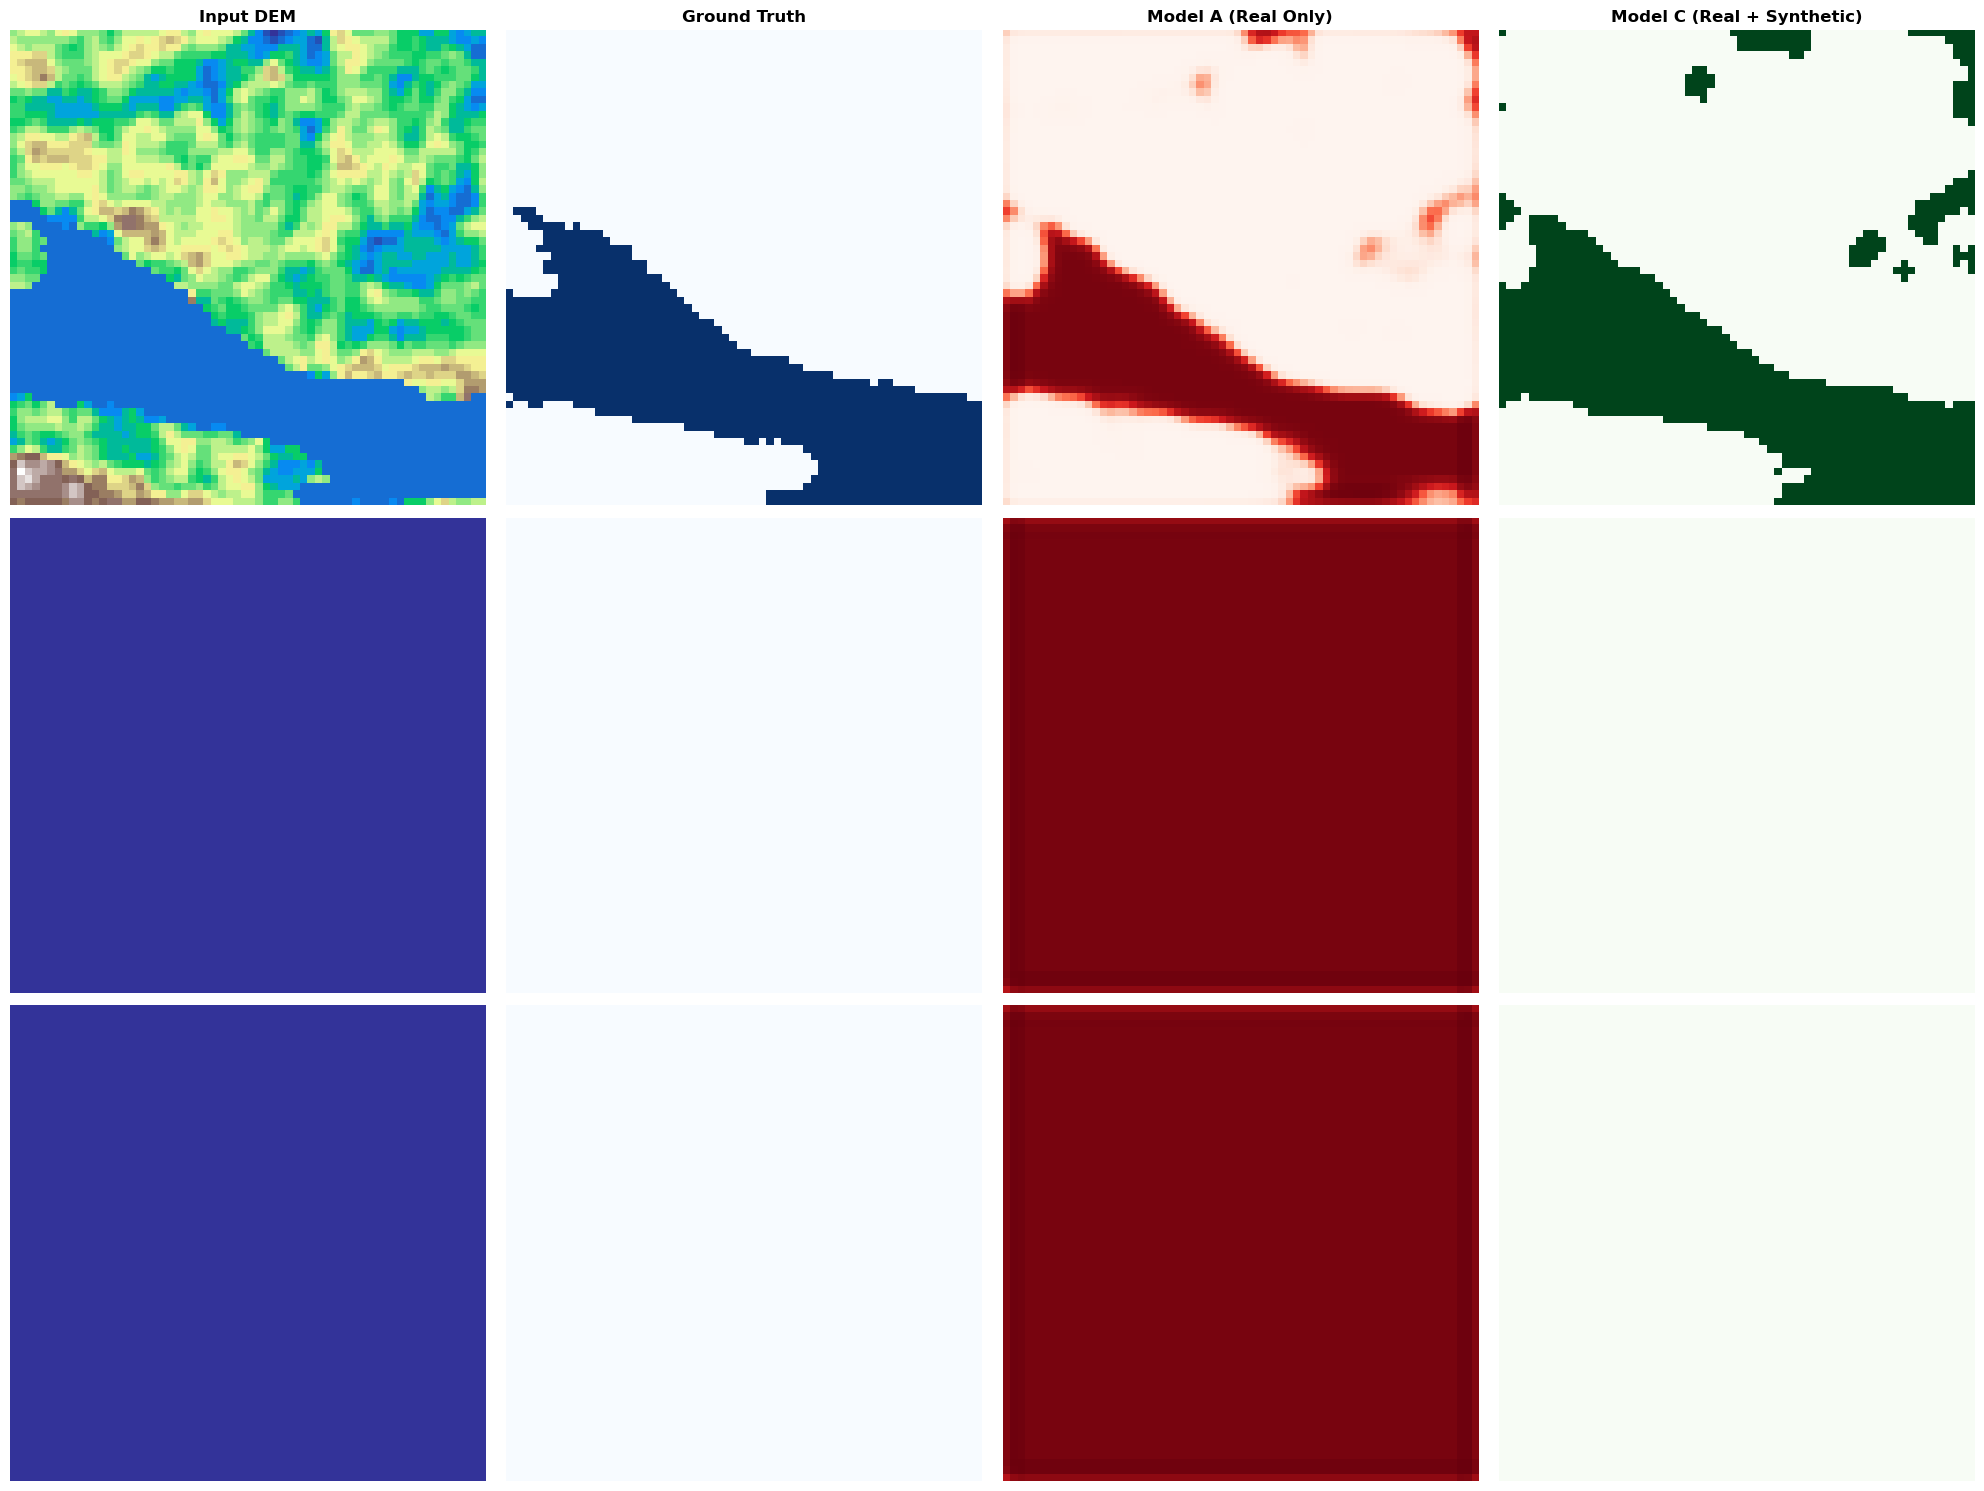

In [42]:
def compare_robustness(model_a, model_c, dataset, device, num_samples=3):
    model_a.eval()
    model_c.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, num_samples * 5))
    
    headers = ['Input DEM', 'Ground Truth', 'Model A (Real Only)', 'Model C (Real + Synthetic)']
    
    # Set headers on the first row
    ax_row = axes[0] if num_samples > 1 else axes
    for ax, col in zip(ax_row, headers):
        ax.set_title(col, fontweight='bold')

    with torch.no_grad():
        for i in range(num_samples):
            # FIX: Define current_axes for this specific row
            current_axes = axes[i] if num_samples > 1 else axes
            
            # Find a "wet" patch
            found = False
            while not found:
                idx = np.random.randint(len(dataset))
                img, mask = dataset[idx]
                if mask.sum() > 10: 
                    found = True
            
            input_tensor = img.unsqueeze(0).to(device)
            
            # Predict
            pred_a = torch.sigmoid(model_a(input_tensor)).squeeze().cpu().numpy()
            pred_c = torch.sigmoid(model_c(input_tensor)).squeeze().cpu().numpy()

            # Plotting
            current_axes[0].imshow(img.squeeze(), cmap='terrain')
            current_axes[1].imshow(mask.squeeze(), cmap='Blues')
            
            # Use Reds for Model A to see raw confidence/probability
            current_axes[2].imshow(pred_a, cmap='Reds', vmin=0, vmax=1)
            
            # Use threshold for Model C to see the final mask
            current_axes[3].imshow(pred_c > 0.5, cmap='Greens')
            
            for j in range(4): 
                current_axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Run it
compare_robustness(model_a, model_c, val_real.dataset, device, num_samples=3)

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import json
results = {
    "Real-only": evaluate(model_a, val_real),
    "Synthetic-only": evaluate(model_b, val_real),
    "Real + Synthetic": evaluate(model_c, val_real)
}

print("\n--- Summary Table ---")
print(json.dumps(results, indent=4))


--- Summary Table ---
{
    "Real-only": {
        "accuracy": 0.9366924046019269,
        "precision": 0.9819739249282581,
        "recall": 0.891168469825176,
        "f1": 0.9343701819334775
    },
    "Synthetic-only": {
        "accuracy": 0.5648831690542596,
        "precision": 0.5411660659592983,
        "recall": 0.9173030553905459,
        "f1": 0.6807319791847289
    },
    "Real + Synthetic": {
        "accuracy": 0.9263767946564402,
        "precision": 0.9723765137996154,
        "recall": 0.8793921692017432,
        "f1": 0.9235497928014643
    }
}
